In [17]:
import pandas as pd
import numpy as np
import yfinance as yf
import arch
from arch.unitroot import ADF
from arch import arch_model
import matplotlib.pyplot as plt

In [4]:
seel = yf.download(tickers="SEEL", period="7d", interval="1m")
zyne = yf.download(tickers="ZYNE", period="7d", interval="1m")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
zyne_adf = ADF(zyne["Close"])
print(zyne_adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.823
P-value                         0.055
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [26]:
zyne_returns = 100 * (zyne["Close"].pct_change().dropna())
zyne_arch = arch_model(zyne_returns, dist="skewt")
zyne_res = zyne_arch.fit()
print(zyne_res.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 428.4342242963286
Iteration:      2,   Func. Count:     20,   Neg. LLF: 428.42661953018956
Iteration:      3,   Func. Count:     30,   Neg. LLF: 427.91998688787953
Iteration:      4,   Func. Count:     40,   Neg. LLF: 427.64562800604523
Iteration:      5,   Func. Count:     50,   Neg. LLF: 427.5795091238193
Iteration:      6,   Func. Count:     59,   Neg. LLF: 427.3305351713992
Iteration:      7,   Func. Count:     68,   Neg. LLF: 427.23729270322514
Iteration:      8,   Func. Count:     77,   Neg. LLF: 427.1132206152216
Iteration:      9,   Func. Count:     85,   Neg. LLF: 427.1067183585103
Iteration:     10,   Func. Count:     93,   Neg. LLF: 427.10523857607313
Iteration:     11,   Func. Count:    101,   Neg. LLF: 427.10451425817905
Iteration:     12,   Func. Count:    109,   Neg. LLF: 427.10394582958656
Iteration:     13,   Func. Count:    117,   Neg. LLF: 427.1039215917705
Optimization terminated successfully.    (Exit mode 0)
  

C:\Users\Michael\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Michael\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


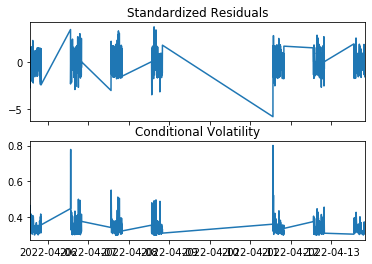

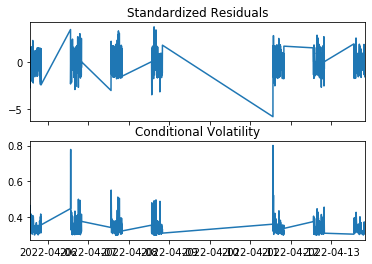

In [27]:
zyne_res.plot()

In [28]:
zyne["Close"]

Datetime
2022-04-05 09:30:00-04:00    2.080
2022-04-05 09:31:00-04:00    2.065
2022-04-05 09:32:00-04:00    2.060
2022-04-05 09:34:00-04:00    2.070
2022-04-05 09:35:00-04:00    2.070
                             ...  
2022-04-13 15:56:00-04:00    1.780
2022-04-13 15:57:00-04:00    1.771
2022-04-13 15:58:00-04:00    1.771
2022-04-13 15:59:00-04:00    1.780
2022-04-13 16:00:00-04:00    1.780
Name: Close, Length: 1310, dtype: float64

In [33]:
zyne_forecast = zyne_res.forecast(horizon=10)
zyne_forecast.variance

C:\Users\Michael\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
Datetime,,,,,,,,,,
2022-04-05 09:31:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-05 09:32:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-05 09:34:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-05 09:35:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-05 09:36:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-04-13 15:56:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-13 15:57:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-13 15:58:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
